<a href="https://colab.research.google.com/github/jrchac/Exploratory-Data-Analysis/blob/main/EDA_Fitbit_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA FitBit Dataset

## Description of the Project

Project: FitBit Activity-Sleep Analysis

Data Set: FitBit Fitness Tracker Data

Source: https://www.kaggle.com/datasets/arashnic/fitbit?select=mturkfitbit_export_4.12.16-5.12.16

Main Objective: Exploratory Data Analysis (EDA) of the FitBit Tracker Data regarding daily activity and sleep patterns.

Exploratory analysis:
- how are physical activity and sleep duration distributed across all users?
- what are the patterns in the relationship between minutes spent in a certain state and sleep duration?
-  how do metrics of physical activity and sleep relate to each other? (correlation analysis)

Specific Questions, we would like to answer based on data:
1. Does the time of day when a user takes the most amount of steps influence sleep duration?
2. Which measures of a user's physical activity influence sleep duration?
3. How accurately can sleep duration be predicted based on measurements of a user's physical activity?


## Exploratory Data Analysis


### General Data Analysis
The first step of the project is to analyze the dataset. The following points help us understand the data:
- short description of the datasets (Daily Activity, Sleep Day and Hourly Steps)
- number of unique users,
- missing values in any feature column, and
- duplicate rows
- visualization of features

In [1]:
# Dataset preprocessing
import numpy as np
import pandas as pd

# Plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# Importing data sets
daily_activity = pd.read_csv('dailyActivity_merged.csv')
sleep_day = pd.read_csv('sleepDay_merged.csv')
hourly_steps = pd.read_csv("hourlySteps_merged.csv")


We check for the number of unique IDs in the three datasets:

In [3]:
print("Number of users in daily activity dataset:",daily_activity['Id'].nunique())
print("Number of users in houtly steps dataset:",hourly_steps['Id'].nunique())
print("Number of users in sleep day dataset:",sleep_day['Id'].nunique())


Number of users in daily activity dataset: 33
Number of users in houtly steps dataset: 33
Number of users in sleep day dataset: 24


Then, we check for missing values:

In [4]:
missing_values = daily_activity.isnull().sum()
print("missing values in daily activity dataset:",missing_values.sum())

missing_values = sleep_day.isnull().sum()
print("missing values in sleep day dataset:", missing_values.sum())

missing_values = hourly_steps.isnull().sum()
print("missing values in hourly steps dataset:", missing_values.sum())
print("no missing values found")

missing values in daily activity dataset: 0
missing values in sleep day dataset: 0
missing values in hourly steps dataset: 0
no missing values found


These are the number of duplicate values in each feature of each data set. Again, only <code>sleep_day</code> contains duplicate values, which are promptly removed.

In [5]:
num_duplicated_1 = daily_activity.duplicated().sum()
print ("Number of duplicates in daily_activity:", num_duplicated_1)

num_duplicated_3 = hourly_steps.duplicated().sum()
print ("Number of duplicates in hourly_steps:", num_duplicated_3)

num_duplicated_2 = sleep_day.duplicated().sum()
print ("Number of duplicates in sleep_day:", num_duplicated_2)
sleep_day = sleep_day.drop_duplicates()


Number of duplicates in daily_activity: 0
Number of duplicates in hourly_steps: 0
Number of duplicates in sleep_day: 3


### Exploring User Activity and Sleep Patterns

First, the variable <code>TotalActiveMinutes</code> is created to measure daily activity regardless of the intensity of the activity. The mean value of this variable, alongside the sleep duration, were calculated per user ID to be used in a bar plot.

In [6]:
daily_activity["TotalActiveMinutes"] = daily_activity["LightlyActiveMinutes"] + daily_activity["FairlyActiveMinutes"] + daily_activity["VeryActiveMinutes"]
daily_ac_user = daily_activity.groupby(["Id"])["TotalActiveMinutes"].mean()
daily_ac_user = daily_ac_user.reset_index()
daily_ac_user = daily_ac_user.sort_values(by = ["TotalActiveMinutes"], ascending = False)

daily_sl_user = sleep_day.groupby(["Id"])["TotalMinutesAsleep"].mean()
daily_sl_user = daily_sl_user.reset_index()
daily_sl_user = daily_sl_user.sort_values(by = ["TotalMinutesAsleep"], ascending = False)

# Merging activity variables with sleep variables
daily_user = pd.merge(daily_ac_user, daily_sl_user, on = ['Id'], how = 'left')
daily_user = pd.melt(daily_user, id_vars = "Id", value_vars = ["TotalActiveMinutes", "TotalMinutesAsleep"])


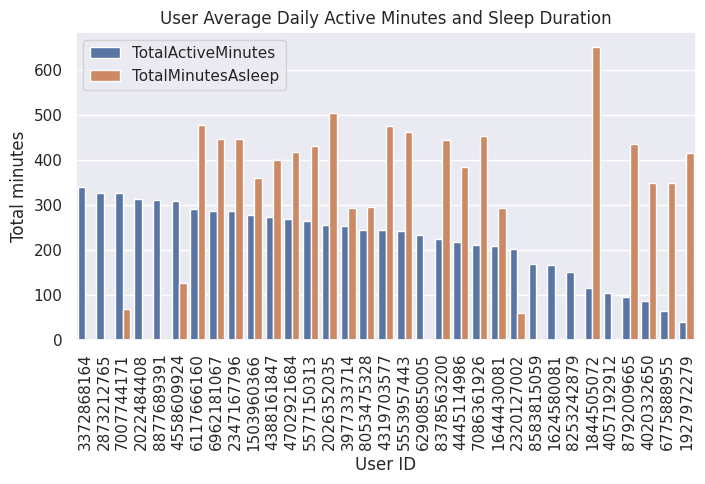

In [7]:
sns.set(rc={"figure.figsize":(8, 4)})
sns.set_style("darkgrid")

sns.barplot(data = daily_user, x = daily_user["Id"], y = daily_user["value"], hue = daily_user["variable"],
            order = daily_ac_user.sort_values("TotalActiveMinutes", ascending = False).Id).set(
            title = "User Average Daily Active Minutes and Sleep Duration",
            xlabel = "User ID", ylabel = "Total minutes")

plt.xticks(rotation = 90)
plt.legend(loc = "upper left")
plt.show()


**Conclusion**:
- we have activity data for all users, but sleep data is available only for a fraction of the data points.
- some outliers in the sleep data are probably errors. These displayed les than an hour of sleep a day. We will remove these outliers for the sleep data.


### Boxplot: Daily activity and sleep duration

In this case, all measurements of daily activity and the sleep duration are considered individually, resulting in the box plot below.

In [8]:
ac_sl_merged = pd.merge(daily_activity, sleep_day, on = ['Id'], how = 'left')
ac_sl_merged = pd.melt(ac_sl_merged, id_vars = "Id", value_vars = ["TotalActiveMinutes", "TotalMinutesAsleep"])

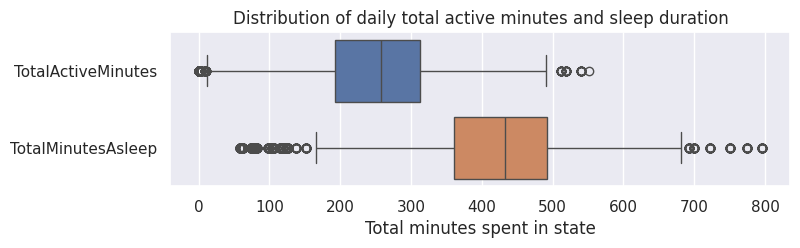

In [9]:
sns.set(rc={"figure.figsize":(8, 2)})
sns.set_style("darkgrid")

sns.boxplot(data = ac_sl_merged, x = ac_sl_merged["value"], y = ac_sl_merged["variable"],
            hue = ac_sl_merged["variable"]).set(title = "Distribution of daily total active minutes and sleep duration",
            xlabel = "Total minutes spent in state", ylabel = "")

# Hiding the legend
plt.legend([],[], frameon = False)
plt.show()


**Conclusion**:
- Just as in the histogram, we see some extreme outliers. These values need to be investigated further.
- Average active minutes a day: aprox 275 (4.5h)
- Average active minutes asleep: aprox 430 (7.2h)

### Unraveling Peak Step Counts Amoung Users Across the Week

Based on the date of the measurement, the day of the week was extracted from <code>daily_activity</code>. The mean of each day of the week was subsequently used to make a bar plot.

In [10]:
daily_activity["ActivityDate"] = pd.to_datetime(daily_activity["ActivityDate"])
daily_activity["Weekday"] = daily_activity["ActivityDate"].dt.day_name()

mean_daily_steps = daily_activity.groupby(["Weekday"]).mean()
mean_daily_steps = mean_daily_steps.reset_index()

# Manually sort days in right order
mean_daily_steps = mean_daily_steps.reindex([1, 5, 6, 4, 0, 2, 3])

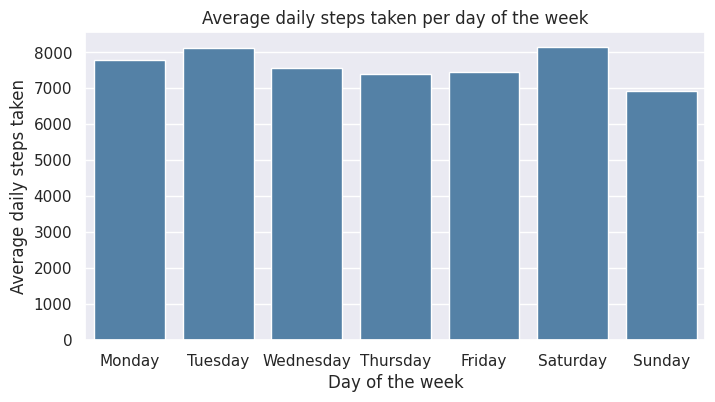

In [11]:
sns.set(rc={"figure.figsize":(8, 4)})
sns.set_style("darkgrid")

sns.barplot(data = mean_daily_steps, x = mean_daily_steps["Weekday"], y = mean_daily_steps["TotalSteps"],
            color= "steelblue").set(title = "Average daily steps taken per day of the week",
            xlabel = "Day of the week", ylabel = "Average daily steps taken")
plt.show()

**Conclusion**:
- Saturday is the most active day, followed by Tuesday and Monday, respectively.
- Sunday is the least active day.
- Rest of days seems very similar

### Exploring Peak Activity Hours Among Individuals

Based on the date and hour of the measurement, the hour of the day was extracted from <code>daily_activity</code>. The mean of each hour of the day was subsequently used to make a line plot.

In [12]:
hourly_steps["ActivityHour"] = pd.to_datetime(hourly_steps["ActivityHour"])
hourly_steps["Hour"] = hourly_steps["ActivityHour"].dt.hour

average_steps_ph = hourly_steps.groupby(["Hour"]).mean()
average_steps_ph = average_steps_ph.reset_index()


<ipython-input-12-a96d3093fc00>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hourly_steps["ActivityHour"] = pd.to_datetime(hourly_steps["ActivityHour"])


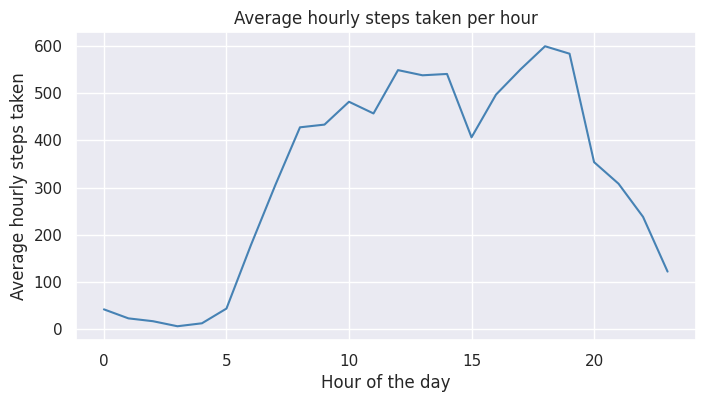

In [13]:
sns.set(rc={"figure.figsize":(8, 4)})
sns.set_style("darkgrid")

sns.lineplot(data = average_steps_ph, x = average_steps_ph["Hour"], y = average_steps_ph["StepTotal"],
             color = "steelblue").set(title = "Average hourly steps taken per hour",
             xlabel = "Hour of the day", ylabel = "Average hourly steps taken")
plt.show()

**Conclusion**:
- Peaks occur around 1 PM and around 6 PM. Again, this is likely related to education or work, as they correspond to the times at which usually take a break or head back home.
- The slopes also align with day-to-day activies. As from 5 to 8, we see the steepest increasing slope. While from 18-20 we see the steepest decreasing slope (when people are already back home)

### Correlation matrix of the activity and sleep dataset combined

The first step is to make sure that the data sets of physical activity and sleep can be merged. After this step, a heat map is made to highlight the different correlation levels of the sleep and activity measurements.

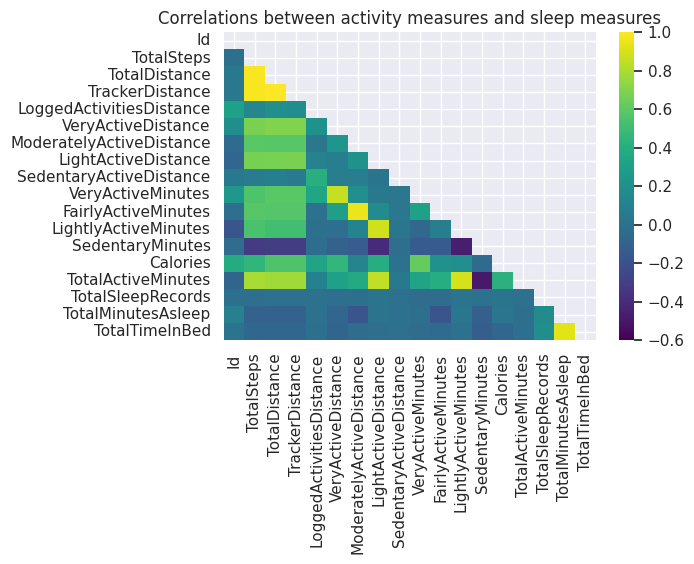

In [14]:
all_vars = pd.merge(daily_activity, sleep_day, on=['Id'])
numeric_columns = all_vars.select_dtypes(include=np.number)

correlation_matrix = numeric_columns.corr()

# Convert correlation matrix to numpy array
matrix = np.triu(correlation_matrix)

sns.set(rc={"figure.figsize": (6, 4)})
sns.set_style("darkgrid")

mps = sns.heatmap(correlation_matrix, vmin=-0.6, vmax=1, annot=False, cmap="viridis", mask=matrix).set(
    title="Correlations between activity measures and sleep measures")

**Conclusion**:
- there are not strong correlation between sleep and activity measurements.
- interest insight: Calories and TotalActiveMinute have a correlation of around 0.5. Further analysis on this will be conducted
- other strong correlations between activity data are easily explainable. For instance, TotalDistance and TotalSteps have a 1 correlation, which makes perfect sense due to its complete dependence.

## Question 1: Does the time of day (morning, afternoon, evening) of physical activity influence sleep duration?

Several steps need to be taken. First, the three users which were pointed out in the first exploratory question as having low average sleep durations need to be removed. Next, categories need to be created to split the hours of a day into four groups, which fall under the column <code>TimeOfDay</code>. Based on the values which appear in this column, the Wilcoxon rank-sum test is performed.

In [15]:
# Performing statistical tests
from scipy import stats
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

In [16]:
activity_sleep = pd.merge(daily_activity, sleep_day, on = ['Id'])
activity_sleep = activity_sleep.drop(columns=['SleepDay', 'TotalSleepRecords'])

In [17]:
# Removing users with suspiciously low average sleep durations
sleep_per_user = activity_sleep.groupby("Id")['TotalMinutesAsleep'].mean()
removed_users = sleep_per_user[sleep_per_user.values < 250].index
print(removed_users.values)

activity_sleep = activity_sleep[~activity_sleep['Id'].isin(removed_users.values)]
len(activity_sleep['Id'].unique())

[2320127002 4558609924 7007744171]


21

In [18]:
hourly_steps["Date"] = pd.to_datetime(hourly_steps["ActivityHour"]).dt.strftime('%m/%d/%Y')
hourly_steps["Hour"] = pd.to_datetime(hourly_steps["ActivityHour"]).dt.hour
hourly_steps = hourly_steps.join(hourly_steps.groupby(["Id", "Date"]).StepTotal.agg(["idxmax"]).set_index("idxmax"), how = "inner")

conditions = [
    (hourly_steps['Hour'] < 6),
    (hourly_steps['Hour'] >= 6) & (hourly_steps['Hour'] < 12),
    (hourly_steps['Hour'] >= 12) & (hourly_steps['Hour'] < 18),
    (hourly_steps['Hour'] >= 18)
]

values = ['Night', 'Morning', 'Afternoon', 'Evening']
hourly_steps['TimeOfDay'] = np.select(conditions, values)


In [19]:
# Making sure the date format is the same for both data sets
sleep_day['Date'] = pd.to_datetime(sleep_day['SleepDay']).dt.strftime('%m/%d/%Y')

merged_daytimes = pd.merge(hourly_steps, activity_sleep, on = ['Id'])
merged_daytimes = merged_daytimes[["Id", "Date", "TimeOfDay", "TotalMinutesAsleep"]]


<ipython-input-19-b0199d07e0cc>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sleep_day['Date'] = pd.to_datetime(sleep_day['SleepDay']).dt.strftime('%m/%d/%Y')


In [20]:
merged_daytimes.groupby('TimeOfDay').count()


,Id,Date,TotalMinutesAsleep
TimeOfDay,,,
Afternoon,135309,135309,135309
Evening,95874,95874,95874
Morning,109218,109218,109218
Night,24937,24937,24937


In [21]:
means = merged_daytimes.groupby("TimeOfDay")['TotalMinutesAsleep'].mean()
means

TimeOfDay
Afternoon    432.259229
Evening      396.070687
Morning      441.349420
Night        434.644584
Name: TotalMinutesAsleep, dtype: float64

Next, we perform some statisticals tests on the data. Specifically, we perform the Wilcoxon rank-sum test, which is non-parametric statistical hypotehesis test.

The tests are being perform to determine if there is statistically significant difference in the total minutes asleep between that are active on different times of the day (night, morning, afternoon, evening).

In [22]:
night = merged_daytimes.loc[merged_daytimes["TimeOfDay"] == "Night"]
morning = merged_daytimes.loc[merged_daytimes["TimeOfDay"] == "Morning"]
afternoon = merged_daytimes.loc[merged_daytimes["TimeOfDay"] == "Afternoon"]
evening = merged_daytimes.loc[merged_daytimes["TimeOfDay"] == "Evening"]

In [23]:
def ranksum_test(column1, column2):
    # Perform rank-sum test
    test_statistic, p_value = stats.ranksums(column1, column2)
    if p_value < 0.05:
        return f"The difference is statistically significant with a p-value of {p_value:.4f}."
    else:
        return "The difference is not statistically significant."

In [24]:
ranksum_test(night["TotalMinutesAsleep"], morning["TotalMinutesAsleep"])

'The difference is statistically significant with a p-value of 0.0000.'

In [25]:
ranksum_test(night["TotalMinutesAsleep"], afternoon["TotalMinutesAsleep"])

'The difference is statistically significant with a p-value of 0.0000.'

In [26]:
ranksum_test(night["TotalMinutesAsleep"], evening["TotalMinutesAsleep"])

'The difference is statistically significant with a p-value of 0.0000.'

In [27]:
ranksum_test(morning["TotalMinutesAsleep"], afternoon["TotalMinutesAsleep"])

'The difference is statistically significant with a p-value of 0.0000.'

In [28]:
ranksum_test(morning["TotalMinutesAsleep"], evening["TotalMinutesAsleep"])

'The difference is statistically significant with a p-value of 0.0000.'

In [29]:
ranksum_test(afternoon["TotalMinutesAsleep"], evening["TotalMinutesAsleep"])

'The difference is statistically significant with a p-value of 0.0000.'

**Conclusion**: sleep duration significantly improves when one takes more steps during the morning as opposed to the evening. Note that the Bonferroni correction is applied, which means that alpha = 0.05/6. Therefore, the last result is also not significant.

## Question 2: Which measures of a user's physical activity influence sleep duration?

Based on the modifications which were performed earlier on, the rank correlation test of Spearman can be applied straight away. The Spearman rank correlation test is a statistical method used to assess the strength and direction of association between two variables. In other words, we would like to measure the connection between different levels of physcal activity and sleep duration.

In [30]:
sc1, sp1 = spearmanr(activity_sleep['Calories'], activity_sleep['TotalMinutesAsleep'])
print("Spearman's rank correlation coefficient (Calories):", sc1)
print("p-value (Calories):", sp1)

sc2, sp2 = spearmanr(activity_sleep['TotalDistance'], activity_sleep['TotalMinutesAsleep'])
print("Spearman's rank correlation coefficient (TotalDistance):", sc2)
print("p-value (TotalDistance):", sp2)

sc3, sp3 = spearmanr(activity_sleep['LightlyActiveMinutes'], activity_sleep['TotalMinutesAsleep'])
print("Spearman's rank correlation coefficient (LightlyActiveMinutes):", sc3)
print("p-value (LightlyActiveMinutes):", sp3)

sc4, sp4 = spearmanr(activity_sleep['FairlyActiveMinutes'], activity_sleep['TotalMinutesAsleep'])
print("Spearman's rank correlation coefficient (FairlyActiveMinutes):", sc4)
print("p-value (FairlyActiveMinutes):", sp4)

sc5, sp5 = spearmanr(activity_sleep['VeryActiveMinutes'], activity_sleep['TotalMinutesAsleep'])
print("Spearman's rank correlation coefficient (VeryActiveMinutes):", sc5)
print("p-value (VeryActiveMinutes):", sp5)


Spearman's rank correlation coefficient (Calories): 0.020984630067760853
p-value (Calories): 0.02092811292887825
Spearman's rank correlation coefficient (TotalDistance): -0.13411379625454187
p-value (TotalDistance): 1.023408946575241e-49
Spearman's rank correlation coefficient (LightlyActiveMinutes): 0.08302343255727514
p-value (LightlyActiveMinutes): 5.629989267455719e-20
Spearman's rank correlation coefficient (FairlyActiveMinutes): -0.1956700971564053
p-value (FairlyActiveMinutes): 8.432049309345767e-105
Spearman's rank correlation coefficient (VeryActiveMinutes): -0.13876436756438987
p-value (VeryActiveMinutes): 3.9398641222464227e-53


**Conclusion**:
1. **Calories:** The correlation coefficient is 0.021 with a p-value of 0.021. Since the p-value is greater than 0.05, we fail to reject the null hypothesis of no correlation between Calories and sleepDuration. Thus, there is no significant correlation between Calories and sleepDuration at a 5% significance level.

2. **TotalDistance:** The correlation coefficient is -0.134 with a p-value much smaller than 0.05 (1.02e-49). This indicates a significant negative correlation between TotalDistance and sleepDuration.

3. **LightlyActiveMinutes:** The correlation coefficient is 0.083 with a p-value much smaller than 0.05 (5.63e-20). Therefore, there is a significant positive correlation between LightlyActiveMinutes and sleepDuration.

4. **FairlyActiveMinutes:** The correlation coefficient is -0.196 with a p-value much smaller than 0.05 (8.43e-105). Hence, there is a significant negative correlation between FairlyActiveMinutes and sleepDuration.

5. **VeryActiveMinutes:** The correlation coefficient is -0.139 with a p-value much smaller than 0.05 (3.94e-53). This implies a significant negative correlation between VeryActiveMinutes and sleepDuration.

In summary, at a 5% significance level, there is a significant negative correlation between TotalDistance, FairlyActiveMinutes, and VeryActiveMinutes with sleepDuration, while LightlyActiveMinutes shows a significant positive correlation. The correlation with Calories remains not significant at this level.


## Question 3: Linear model - Prediction of sleep duration through physical activity measurements

The first step of this analysis is to determine the most important feature for predicting sleep duration. We will achieve this by creating a random forest model and ranking its features by importance for predicting sleep duration.

In [31]:
# Implementing ML models
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [32]:
X = activity_sleep[["Calories", "TotalSteps", "TotalDistance", "TotalActiveMinutes",
                    "LightlyActiveMinutes", "FairlyActiveMinutes", "VeryActiveMinutes"]]
y = activity_sleep['TotalMinutesAsleep']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# random forest regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# extracting the importance of the features
importance_tiers = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
importance_tiers = importance_tiers.sort_values(by = 'Importance', ascending = False)
print(importance_tiers)

                Feature  Importance
0              Calories    0.427926
5   FairlyActiveMinutes    0.147465
1            TotalSteps    0.098075
4  LightlyActiveMinutes    0.091726
2         TotalDistance    0.087928
3    TotalActiveMinutes    0.075912
6     VeryActiveMinutes    0.070967


**Conclusion:** Based on the random forest model, the feature importance of the variable <code>Calories</code> is the most significant predictor for the sleep duration. It must be noted that sedentary minutes would be a stronger predictor, but due to the results of the data analysis shown earlier, this variable was not considered.

In [34]:
target = "TotalMinutesAsleep"
feature_column = "Calories"

Next, we create different machine learning models. We will train all these different models on the same data and then compare their results.


To implement the machine learning algorithms, we first employed grid search to explore hyperparameter tuning and cross-validation, selecting the parameters with the lowest RMSE score on the training set for the final prediction.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    activity_sleep[feature_column].values.reshape(-1, 1),
    activity_sleep[target],
    test_size=0.2,
    random_state=42
)

In [36]:
# Linear Regression Model
linear_model = LinearRegression()
linear_grid = [{ "n_jobs": [1,2,3,4,5,6,7]}]
linear_search = GridSearchCV(linear_model, linear_grid)
linear_search.fit(X_train, y_train)
final_linear = linear_search.best_estimator_
linear_predictions = final_linear.predict(X_test)
linear_rmse = mean_squared_error(y_test, linear_predictions, squared=False)

In [37]:
# K-Neighbors Regressor Model
knn_model = KNeighborsRegressor()
knn_grid = [{"n_neighbors":[3,4,5,6,7], "weights":["uniform", 'distance']}]
knn_search = GridSearchCV(knn_model, knn_grid)
knn_search.fit(X_train, y_train)
final_knn = knn_search.best_estimator_
knn_predictions = final_knn.predict(X_test)
knn_rmse = mean_squared_error(y_test, knn_predictions, squared=False)
# Hyperparameters for KNN: n_neighbors=7

In [38]:
# Decision Tree Model
dt_model = DecisionTreeRegressor(random_state=42)
dt_grid = [{"criterion":["squared_error"], "splitter":['best','random'], 'min_samples_split':[2,3,4]}]
dt_search = GridSearchCV(dt_model, dt_grid)
dt_search.fit(X_train, y_train)
final_dt = dt_search.best_estimator_
dt_predictions = final_dt.predict(X_test)
dt_rmse = mean_squared_error(y_test, dt_predictions, squared=False)
# Hyperparameters for Decision Tree: min_samples_split=4, splitter='random'

In [39]:
# Random Forest Model
rf_model = RandomForestRegressor(random_state=42)
rf_grid = [{'n_estimators':[60,80,100,120,150],'criterion':['squared_error']}]
rf_search = GridSearchCV(rf_model, rf_grid)
rf_search.fit(X_train, y_train)
final_rf = rf_search.best_estimator_
rf_predictions = final_rf.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
# Hyperparameters for Random Forest: n_estimators=150, random_state=42

In [40]:
# printing hyperparameters found
print("Hyperparameters:\n")
print(final_linear)
print(final_knn)
print(final_dt)
print(final_rf,"\n")

Hyperparameters:

LinearRegression(n_jobs=1)
KNeighborsRegressor(n_neighbors=7)
DecisionTreeRegressor(min_samples_split=4, random_state=42, splitter='random')
RandomForestRegressor(n_estimators=60, random_state=42) 



In [41]:
# printing results
print(f"Metrics for TotalMinutesAsleep:\n")
print("Linear Regression RMSE:", linear_rmse)
print("KNN RMSE:", knn_rmse)
print("Decision Tree RMSE:", dt_rmse)
print("Random Forest RMSE:", rf_rmse)

Metrics for TotalMinutesAsleep:

Linear Regression RMSE: 112.52103079539009
KNN RMSE: 106.51417136637525
Decision Tree RMSE: 104.34084450175492
Random Forest RMSE: 103.66118767161491


**Conclusion**:
- The lower the RMSE, the better the model's predictive performance. Based on these results, the Random Forest model appears to be the most accurate among the ones tested for predicting TotalMinutesAsleep.